# NO WINDOW FFT

In [1]:
# lets generate signal and noise samples of 5dB SNR
import numpy as np
from scipy import integrate, fftpack, signal, io, stats
import scipy.io.wavfile
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
# initialization for bandwidth of audio wav file
samp_rate, sig = io.wavfile.read("Casio-MT-45-16-Beat.wav")
# extract mono signal
sig = sig.mean(axis=1)
max_time = len(sig)/samp_rate
t = np.linspace(0, max_time, len(sig))

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [3]:
# get the complex signal of a signal
def complex_sig(real_sig):
    return signal.hilbert(real_sig)

In [4]:
comp_sig = complex_sig(sig)

In [5]:
def add_wgnoise(sig):
    # get power of signal
    sig_pow = np.var(sig)
    # compute noise power at 5dB SNR
    snr_lin = 10**(10/10)
    noise_pow = sig_pow/snr_lin
    noise = stats.norm(0, np.sqrt(noise_pow))
    return sig + noise.rvs(*np.shape(sig))

In [6]:
sig_plus_noise = add_wgnoise(comp_sig)

In [7]:
# plot fft of sig
nfft = 1024
F_sig_plus_noise = fftpack.fft(sig_plus_noise, nfft)
f = np.linspace(0, samp_rate, nfft)

Text(0.5, 0, 'frequency')

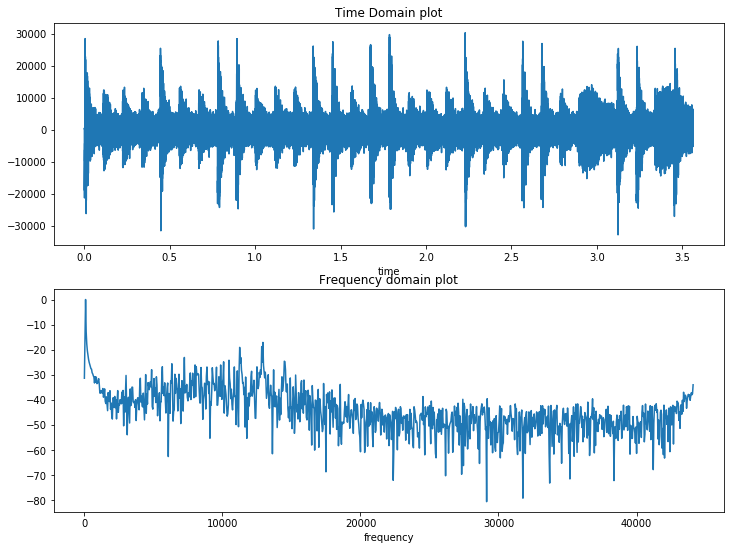

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12,9))
ax[0].plot(t, np.real(sig_plus_noise))
ax[0].set_title("Time Domain plot")
ax[0].set_xlabel("time")

ax[1].plot(f, 20*np.log10(abs(F_sig_plus_noise)/max(abs(F_sig_plus_noise))))
ax[1].set_title("Frequency domain plot")
ax[1].set_xlabel("frequency")

# SLIDING WINDOW FFT

In [9]:
# 0.5 seconds of sample rate is 22050 samples
# we will use blackmann harris window within the signal module
# lets define a function for computing the sliding window fft
def subDomainFFT(sig, samp_rate):
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        F_arr = np.zeros((niteration, nfft), dtype=complex)
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            # append to fft array
            F_arr[i, :] = F_slide
        return F_arr, nfft, niteration
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")

In [10]:
F_slide_fft, nfft, niteration = subDomainFFT(sig_plus_noise, samp_rate)
f = np.linspace(0, samp_rate, num=nfft)

Text(0.5, 0, 'frequency')

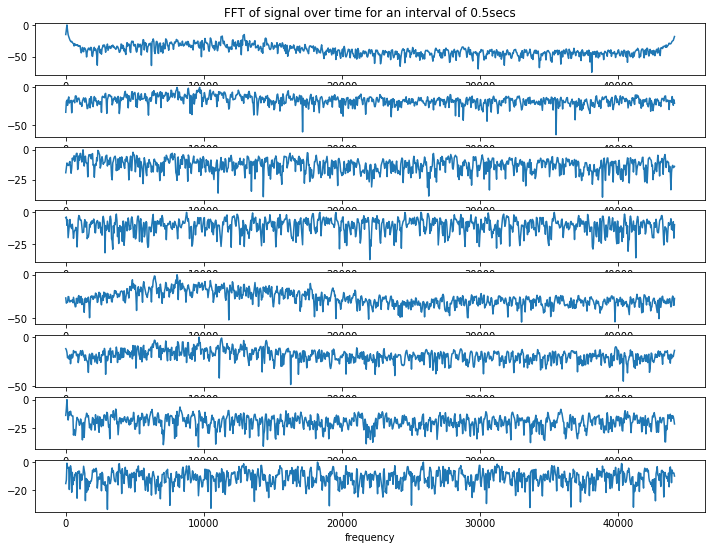

In [11]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("FFT of signal over time for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
ax[niteration-1].set_xlabel("frequency")

*Algorithm steps*
- Compute 1024 fft bins of 0.5 seconds of sample rate and shift by half number of samples
- Compute fixed smoothing factor of smoothing window of 0.5 seconds (Ans:0.3333)
- Find smoothed periodogram of window samples ie 1024 fft samples of sliding window
- Find the minimum of 384 samples (maintain a 3/8 ratio between range of samples to choose and the fft bin length)

In [12]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate1(sig, samp_rate):
    """A noise floor estimator with fixed smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            # compute periodogram
            alpha = 0.3333
            if i == 0: # for the first window
                prev_pdogram = 0
            pdogram, prev_pdogram = periodogram(F_slide, prev_pdogram, alpha)
            pdogram_final[i, :] =  pdogram
        
               
            # find minimum sample in 3 of 8 samples
            win_min = 3*nfft//8
            noise_estimate = []
            for k in range(len(pdogram)): # number of iteration
                if k == 0 and i == 0: # for the first window
                    nzero = win_min - 1
                    nzero_arr = np.ones((nzero))*10*np.log10(float(pdogram[0:1]))
                    noise_range = np.append(nzero_arr, 10*np.log10(pdogram)) # noise range has length (win_len - 1) + 1024 
                elif k == 0: 
                    noise_range = np.append(noise_range, 10*np.log10(pdogram)) # append length of 1024
                # compute noise floor estimate
                min_noise = min(noise_range[(k+i*len(pdogram)):(k+i*len(pdogram))+win_min]) # shift periodogram by one sample to the right
                noise_estimate = np.append(noise_estimate, min_noise)
            noise_estimate_arr[i, :] = noise_estimate
            
        return pdogram_final, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def periodogram(F_sig, prev_periodogram, alpha):    
    """Compute the periodogram"""
    periodogram = []
    for n in range(len(F_sig)): # for the length of sample considered
        # smoothen the sequence one sample at a time
        pres_periodogram = alpha*prev_periodogram + (1 - alpha)*abs(F_sig[n])**2
        prev_periodogram = pres_periodogram
        periodogram = np.append(periodogram, pres_periodogram)
    return periodogram, prev_periodogram 

In [13]:
periodogram, noise_floor_est = noise_floor_estimate1(sig_plus_noise, samp_rate)

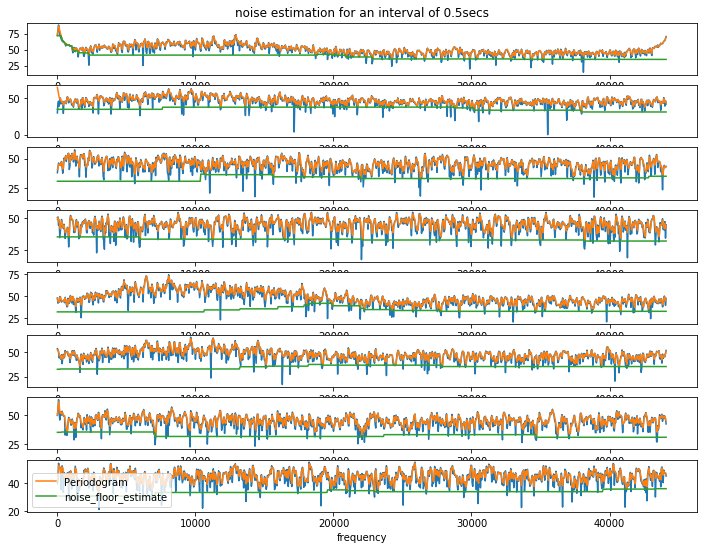

In [14]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("noise estimation for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])))
    ax[i].plot(f, 10*np.log10(periodogram[i]), label="Periodogram")
    ax[i].plot(f, noise_floor_est[i], label="noise_floor_estimate")
ax[niteration-1].set_xlabel("frequency")
ax[niteration-1].legend()

# Concise minimum statistics noise estimator
*Additions to above algorithm*
- compute variable smoothening factor alpha for each 0.5 sec window
- Bound the upper limit by 0.96 to avoid dead lock
- compute normalized equivalent variance for finding the mean of the minimum statistics (optimizing noise estimator)
- compute mean normalized equivalent variance for compensation on changing noise estimation based on the variance of peridogram and by empirical means limit variance to the 0.8 - 9 dB range deviation

In [15]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate2(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                alpha_prev = last_pdogram = last_noise_est = 0
                prev_pdogram = np.ones((nfft))*float(F_slide[0:1]**2)
            else:  # set previous pdogram
                prev_pdogram = pdogram_final[i-1, :] # get last frame of periodogram
                last_noise_est = float(noise_estimate_arr[i-1, -2:-1]) # get last noise estimate
            pdogram, noise_estimate, last_pdogram, alpha_prev = \
            algorithm(F_slide, prev_pdogram, last_pdogram, last_noise_est, alpha_prev)
            pdogram_final[i, :] =  pdogram
            noise_estimate_arr[i, :] = noise_estimate
            
        return pdogram_final, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def algorithm(F_sig, prev_periodogram, last_periodogram, min_noise, last_alpha_cor):    
    """Compute the periodogram"""
    periodogram = []
    noise_estimate = []
    alpha_max = 0.96 # upper limit on alpha_var
    # compute short term psd for each frame
    x = sum(prev_periodogram)/sum(abs(F_sig)**2) - 1
    corfac_term = 0.3*max(1/(1+x**2), 0.7)
    print("Correction factor per frame is {0}, last minimum noise sample is {1}\
    and the last correction factor is {2}".format(corfac_term, min_noise, last_alpha_cor))
    # in each frame
    for n in range(len(F_sig)):
        # compute optimum smoothening factor with previous estimated noise sample
        alpha_opt = 1/(1 + (last_periodogram/10**(min_noise/10) - 1)**2)
        alpha_cor = 0.7*last_alpha_cor + corfac_term
        alpha_var = alpha_max*alpha_cor*alpha_opt
        pres_periodogram = alpha_var*last_periodogram + (1 - alpha_var)*F_sig[n]**2
        # find minimum sample in 3 of 8 samples
        win_min = 3*len(F_sig)//8
        # append periodogram samples for a frame
        if n == 0 : #for the first sample in a frame
            noise_range = 10*np.log10(\
                            prev_periodogram[len(F_sig)-win_min+1:]) # get win_len -1 previous samples
        else:
            noise_range = np.append(noise_range, 10*np.log10(pres_periodogram))
        # slide through 3 of 8 samples
        min_noise = min(noise_range[n:n+win_min])
        last_alpha_cor = alpha_cor
        last_periodogram = pres_periodogram
        periodogram = np.append(periodogram, pres_periodogram)
        noise_estimate = np.append(noise_estimate, min_noise)
    return periodogram, noise_estimate, last_periodogram, last_alpha_cor 

In [16]:
periodogram, noise_floor_est = noise_floor_estimate2(sig_plus_noise, samp_rate)

Correction factor per frame is 0.21, last minimum noise sample is 0    and the last correction factor is 0
Correction factor per frame is 0.21, last minimum noise sample is -74.06557392927806    and the last correction factor is 0.6999999999999997
Correction factor per frame is 0.23208580810251359, last minimum noise sample is -62.86470174823311    and the last correction factor is 0.6999999999999997
Correction factor per frame is 0.2580327920582362, last minimum noise sample is -39.82479158768386    and the last correction factor is 0.7736193603417116
Correction factor per frame is 0.21, last minimum noise sample is -35.40628077437591    and the last correction factor is 0.860109306860787
Correction factor per frame is 0.2230880363571887, last minimum noise sample is -54.11482131501408    and the last correction factor is 0.7
Correction factor per frame is 0.239517797415778, last minimum noise sample is -44.16155255761439    and the last correction factor is 0.7436267878572953
Correct

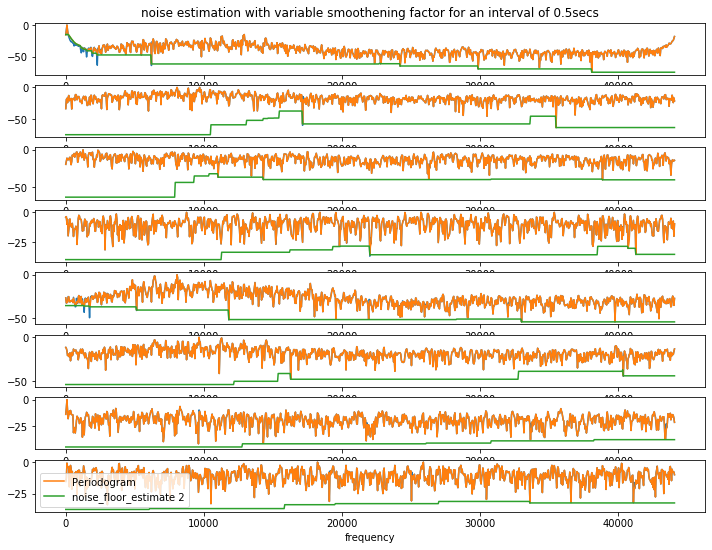

In [17]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[i].plot(f, 10*np.log10(periodogram[i]), label="Periodogram")
    ax[i].plot(f, noise_floor_est[i], label="noise_floor_estimate 2")
ax[niteration-1].set_xlabel("frequency")
ax[niteration-1].legend()

## Plot of concise minimum noise estimator with variable smoothening factor

In [18]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate3(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        valpha_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                alpha_prev = last_pdogram = last_noise_est = 0
                prev_pdogram = np.ones((nfft))*float(F_slide[0:1]**2)
            else:  # set previous pdogram
                prev_pdogram = pdogram_final[i-1, :] # get last frame of periodogram
                last_noise_est = float(noise_estimate_arr[i-1, -2:-1]) # get last noise estimate
            pdogram, noise_estimate, last_pdogram, alpha_prev, valpha = \
            algorithm(F_slide, prev_pdogram, last_pdogram, last_noise_est, alpha_prev)
            pdogram_final[i, :] =  pdogram
            noise_estimate_arr[i, :] = noise_estimate
            valpha_arr[i, :] = valpha
            
        return pdogram_final, valpha_arr, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def algorithm(F_sig, prev_periodogram, last_periodogram, min_noise, last_alpha_cor):    
    """Compute the periodogram"""
    periodogram = []
    noise_estimate = []
    valpha = []
    alpha_max = 0.96 # upper limit on alpha_var
    # compute short term psd for each frame
    x = sum(prev_periodogram)/sum(abs(F_sig)**2) - 1
    corfac_term = 0.3*max(1/(1+x**2), 0.7)
    # in each frame
    for n in range(len(F_sig)):
        # compute optimum smoothening factor with previous estimated noise sample
        alpha_opt = 1/(1 + (last_periodogram/10**(min_noise/10) - 1)**2)
        alpha_cor = 0.7*last_alpha_cor + corfac_term
        alpha_var = alpha_max*alpha_cor*alpha_opt
        pres_periodogram = alpha_var*last_periodogram + (1 - alpha_var)*F_sig[n]**2
        # find minimum sample in 3 of 8 samples
        win_min = 3*len(F_sig)//8
        # append periodogram samples for a frame
        if n == 0 : #for the first sample in a frame
            noise_range = 10*np.log10(\
                            prev_periodogram[len(F_sig)-win_min+1:]) # get win_len -1 previous samples
        else:
            noise_range = np.append(noise_range, 10*np.log10(pres_periodogram))
        # slide through 3 of 8 samples
        min_noise = min(noise_range[n:n+win_min])
        last_alpha_cor = alpha_cor
        last_periodogram = pres_periodogram
        periodogram = np.append(periodogram, pres_periodogram)
        noise_estimate = np.append(noise_estimate, min_noise)
        valpha = np.append(valpha, alpha_var)
    return periodogram, noise_estimate, last_periodogram, last_alpha_cor, valpha 

In [19]:
periodogram, valpha, noise_floor_est = noise_floor_estimate3(sig_plus_noise, samp_rate)

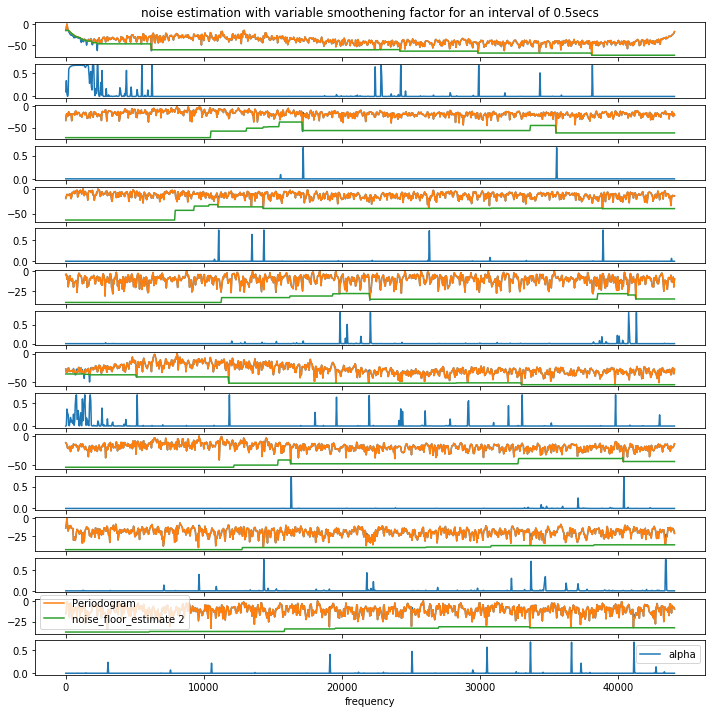

In [20]:
fig, ax = plt.subplots(niteration*2, 1, figsize=(12,12))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[2*i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[2*i].plot(f, 10*np.log10(periodogram[i]/max(periodogram[i])), label="Periodogram")
    ax[2*i].plot(f, noise_floor_est[i], label="noise_floor_estimate 2")
    ax[2*i + 1].plot(f, valpha[i], label="alpha")
ax[niteration*2-1].set_xlabel("frequency")
ax[niteration*2-1].legend()
ax[niteration*2-2].legend()

## optimizing minimum noise stats

- introduce the bais factor as well as the correction factor

In [24]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate4(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        valpha_arr = np.zeros((niteration, nfft))
        eq_deg_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                alpha_prev = last_pdogram = last_noise_est = avg_norm = 0
                last_mean_pdogram = last_mean_sqr_pdogram = 0
                prev_pdogram = np.ones((nfft))*float(F_slide[0:1])
            else:  # set previous pdogram
                prev_pdogram = pdogram_final[i-1, :] # get last frame of periodogram
                last_noise_est = float(noise_estimate_arr[i-1, -2:-1]) # get last noise estimate
                # compute average normalized variance
                avg_norm = sum(eq_deg_arr[i-1, :])/len(eq_deg_arr[i-1, :])
                
            pdogram, noise_estimate, last_pdogram, alpha_prev, valpha,\
            last_mean_pdogram, last_mean_sqr_pdogram, eq_deg_per_frame = \
            algorithm(F_slide, prev_pdogram, last_pdogram, last_noise_est, alpha_prev,\
                      last_mean_pdogram, last_mean_sqr_pdogram, avg_norm)
            pdogram_final[i, :] =  pdogram
            noise_estimate_arr[i, :] = noise_estimate
            valpha_arr[i, :] = valpha
            eq_deg_arr[i, :] = eq_deg_per_frame
            
        return pdogram_final, valpha_arr, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def algorithm(F_sig, prev_periodogram, last_periodogram, min_noise, last_alpha_cor,\
              prev_fmoment, prev_smoment, avg_norm):    
    """Compute the periodogram"""
    periodogram = []
    noise_estimate = []
    valpha = []
    eq_deg_per_frame = []
    alpha_max = 0.96 # upper limit on alpha_var
    print("Average normalized variance is", avg_norm)
    # compute short term psd for each frame
    x = sum(prev_periodogram)/sum(abs(F_sig)**2) - 1
    corfac_term = 0.3*max(1/(1+x**2), 0.7)
    # in each frame
    for n in range(len(F_sig)):
        # compute optimum smoothening factor with previous estimated noise sample
        alpha_opt = 1/(1 + (last_periodogram/10**(min_noise/10) - 1)**2)
        alpha_cor = 0.7*last_alpha_cor + corfac_term
        alpha_var = alpha_max*alpha_cor*alpha_opt
        beta_var = min(alpha_var**2, 0.8)
#         print("variable smootheneing factor beta is ", beta_var)
        pres_periodogram = alpha_var*last_periodogram + (1 - alpha_var)*F_sig[n]**2
        # compute firt moment of periodogrm
        fmoment = beta_var*prev_fmoment + (1 - beta_var)*pres_periodogram
        # compute second moment of periodogram
        smoment = beta_var*prev_smoment + (1 - beta_var)*pres_periodogram**2
        # estimated variance
        est_var = abs(smoment - fmoment)
#         print("Estimated variance is", est_var)
        # equivalent degree of freedom
        eq_deg = 20*np.log10(0.5*est_var)-min_noise
        eq_deg = min(10**(eq_deg/10), 0.5)
#         print("Equivalent degree of freedom",1/eq_deg) # should be greater than or equal to two
        # find minimum sample in 3 of 8 samples
        win_min = 3*len(F_sig)//8
        # computing inverse bias
        eq_deg_tilda = (1/eq_deg - 2/3)/(1 - 1/3)
#         print("The simplified equivalent degree of freedom is", eq_deg_tilda)
        bias = (win_min - 1)*2/eq_deg_tilda
        bias = 1 + bias
        # append periodogram samples for a frame
        if n == 0 : #for the first sample in a frame
            noise_range = 10*np.log10(\
                            bias*prev_periodogram[len(F_sig)-win_min+1:]) # get win_len-1 previous samples
            
        noise_range = np.append(noise_range, 10*np.log10(bias*pres_periodogram))
        
        print("The Bias or inverse mean is", bias)
#         db constraints between 0.8-9dB
        if avg_norm < 0.03:
            noise_slope_max = 9
        elif avg_norm < 0.05:
            noise_slope_max = 6
        elif avg_norm < 0.06:
            noise_slope_max = 3
        else:
            noise_slope_max = 0.8
        # slide through 3 of 8 samples
        min_stats = min(noise_range[n:n+win_min])
        min_noise = min_stats+noise_slope_max
#         print("min noise is", min_noise)
        last_alpha_cor = alpha_cor
        last_periodogram = pres_periodogram
        last_mean_pdogram = fmoment
        last_mean_sqr_pdogram = smoment
        periodogram = np.append(periodogram, pres_periodogram)
        noise_estimate = np.append(noise_estimate, min_noise)
        valpha = np.append(valpha, alpha_var)
        eq_deg_per_frame = np.append(eq_deg_per_frame, eq_deg)
    return periodogram, noise_estimate, last_periodogram, last_alpha_cor, valpha,\
           last_mean_pdogram, last_mean_sqr_pdogram, eq_deg_per_frame

In [25]:
periodogram, valpha, noise_floor_est = noise_floor_estimate4(sig_plus_noise, samp_rate)

Average normalized variance is 0
The Bias or inverse mean is 1.0942774565218618
The Bias or inverse mean is 7.62352178065668
The Bias or inverse mean is 19.72556984923132
The Bias or inverse mean is 15.125187478951307
The Bias or inverse mean is 4.211852401303617
The Bias or inverse mean is 2.2796335882672207
The Bias or inverse mean is 1.3687901852232227
The Bias or inverse mean is 1.0825542031072968
The Bias or inverse mean is 1.0393294211452928
The Bias or inverse mean is 1.0266492205371378
The Bias or inverse mean is 1.02909052434164
The Bias or inverse mean is 1.0205931958972214
The Bias or inverse mean is 1.0146161735902
The Bias or inverse mean is 1.0126454067075967
The Bias or inverse mean is 1.0058777139152968
The Bias or inverse mean is 1.0155050167156725
The Bias or inverse mean is 1.0088422144036442
The Bias or inverse mean is 1.0084230332472408
The Bias or inverse mean is 1.0090860187760056
The Bias or inverse mean is 1.0069400158602189
The Bias or inverse mean is 1.009481

The Bias or inverse mean is 1.0429270094886134
The Bias or inverse mean is 1.0245981581356285
The Bias or inverse mean is 1.0155339830609675
The Bias or inverse mean is 1.0276173508835804
The Bias or inverse mean is 1.014104947423431
The Bias or inverse mean is 1.0189227408865011
The Bias or inverse mean is 1.0464354821010844
The Bias or inverse mean is 1.0125211263234826
The Bias or inverse mean is 1.0033765498223415
The Bias or inverse mean is 1.002911159114317
The Bias or inverse mean is 1.0057298971564683
The Bias or inverse mean is 1.025068356157449
The Bias or inverse mean is 1.016255280486876
The Bias or inverse mean is 1.018119203103581
The Bias or inverse mean is 1.0196892477255604
The Bias or inverse mean is 1.0171729248516141
The Bias or inverse mean is 1.0149914680664291
The Bias or inverse mean is 1.0330105865773853
The Bias or inverse mean is 1.0450443429492329
The Bias or inverse mean is 1.0157298074191454
The Bias or inverse mean is 1.0074385314998373
The Bias or invers

The Bias or inverse mean is 1.0009157104010764
The Bias or inverse mean is 1.0093414168932227
The Bias or inverse mean is 1.0218774413292164
The Bias or inverse mean is 1.0284650596674925
The Bias or inverse mean is 1.0220592930076666
The Bias or inverse mean is 1.0160367065939142
The Bias or inverse mean is 1.0065917780839628
The Bias or inverse mean is 1.0029742852354524
The Bias or inverse mean is 1.0050471766521458
The Bias or inverse mean is 1.0030404166211782
The Bias or inverse mean is 1.0017700010916732
The Bias or inverse mean is 1.0009038661968674
The Bias or inverse mean is 1.0012601420870049
The Bias or inverse mean is 1.000543063539069
The Bias or inverse mean is 1.0013879048317391
The Bias or inverse mean is 1.0053351518561995
The Bias or inverse mean is 1.0063523298157633
The Bias or inverse mean is 1.0035033024993458
The Bias or inverse mean is 1.0047957316023328
The Bias or inverse mean is 1.0204081381368275
The Bias or inverse mean is 1.0288411624005829
The Bias or in

The Bias or inverse mean is 1.0010965494775583
The Bias or inverse mean is 1.0012782023105482
The Bias or inverse mean is 1.0032304485019594
The Bias or inverse mean is 1.0026512451237528
The Bias or inverse mean is 1.0015290523029632
The Bias or inverse mean is 1.0036052220246678
The Bias or inverse mean is 1.0026638451856251
The Bias or inverse mean is 1.0011394055765708
The Bias or inverse mean is 1.0013970456618473
The Bias or inverse mean is 1.0014792008378837
The Bias or inverse mean is 1.0005457778368114
The Bias or inverse mean is 1.000688468066894
The Bias or inverse mean is 1.0024165084764545
The Bias or inverse mean is 1.001189060824207
The Bias or inverse mean is 1.0009552990370814
The Bias or inverse mean is 1.0023937344086495
The Bias or inverse mean is 1.0015865882517776
The Bias or inverse mean is 1.000816645899931
The Bias or inverse mean is 1.0022475573352216
The Bias or inverse mean is 1.0025733678016442
The Bias or inverse mean is 1.001901656342543
The Bias or inver

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.1565387506496574
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 29.63387939215382
The Bias or inverse mean is 102.25830410679836
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 91.89819046371788
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.

The Bias or inverse mean is 108.16650824946595
The Bias or inverse mean is 13.132048311272781
The Bias or inverse mean is 85.13944886693818
The Bias or inverse mean is 384.0
The Bias or inverse mean is 223.50067571291984
The Bias or inverse mean is 4.091389017482012
The Bias or inverse mean is 384.0
The Bias or inverse mean is 99.48013912799723
The Bias or inverse mean is 1.000273099352162
The Bias or inverse mean is 132.15192179271116
The Bias or inverse mean is 14.258271196149053
The Bias or inverse mean is 5.750666483120556
The Bias or inverse mean is 113.54755123781237
The Bias or inverse mean is 48.14033098534458
The Bias or inverse mean is 2.349612200314775
The Bias or inverse mean is 256.3181627042412
The Bias or inverse mean is 63.474460789322656
The Bias or inverse mean is 10.373076885599588
The Bias or inverse mean is 1.4454892163929833
The Bias or inverse mean is 12.045210770079809
The Bias or inverse mean is 224.80913482176524
The Bias or inverse mean is 384.0
The Bias or i

The Bias or inverse mean is 7.582967841766934
The Bias or inverse mean is 24.35241283479976
The Bias or inverse mean is 73.82280088548511
The Bias or inverse mean is 118.88168916679143
The Bias or inverse mean is 384.0
The Bias or inverse mean is 139.1868891944945
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 3.8785242325664435
The Bias or inverse mean is 294.56596424693646
The Bias or inverse mean is 108.92618569936424
The Bias or inverse mean is 204.10148207437328
The Bias or inverse mean is 67.19514319377552
The Bias or inverse mean is 162.11264721588608
The Bias or inverse mean is 8.045529282907655
The Bias or inverse mean is 183.7376958682489
The Bias or inverse mean is 48.179324468074206
The Bias or inverse mean is 2.1639976605834605
The Bias or inverse mean is 29.727373699919077
The Bias or inverse mean is 24.381521499636637
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 246.998994

The Bias or inverse mean is 280.4050479254255
The Bias or inverse mean is 18.44950773855848
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 4.453292680426755
The Bias or inverse mean is 384.0
The Bias or inverse mean is 273.85065254662607
The Bias or inverse mean is 294.6640184039076
The Bias or inverse mean is 218.3261307202569
The Bias or inverse mean is 324.44477049540745
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 172.75938805209387
The Bias or inverse mean is 145.136533030107
The Bias or inverse mean is 137.65758515397965
The Bias or inverse mean is 57.689697194826046
The Bias or inverse mean is 15.387746272600403
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 77.0321598090371
The Bias or inverse mean

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 204.32457213520826
The Bias or inverse mean is 1.3208003225306895
The Bias or inverse mean is 3.6919445722487776
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 12.597616187211758
The Bias or inverse mean is 11.597864757224931
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 7.808770920410815
The Bias or inverse mean is 200.59991541492337
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 86.99709663787559
The Bias or inverse mean is 42.9866666322382
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 2.0119604444681416
The Bias or inverse mean is 32.30859570848828
The Bias or inverse mean is 166.40287792758775

The Bias or inverse mean is 50.7561982767021
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 11.963543140158096
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 78.13719346453269
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 126.93973261891453
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 50.54089822535962
The Bias or inverse mean is 63.76681408152744
The Bias or inverse mean is 2.4435888936314454
The Bias or inverse mean is 384.0
The Bias or inverse mean is 266.9249734195951
The Bias or inverse mean is 384.0
The Bias or invers

The Bias or inverse mean is 384.0
The Bias or inverse mean is 269.25540894410074
The Bias or inverse mean is 1.4179906541204077
The Bias or inverse mean is 146.38281199738927
The Bias or inverse mean is 1.0155277488589627
The Bias or inverse mean is 32.507278796019605
The Bias or inverse mean is 15.666588433534509
The Bias or inverse mean is 384.0
The Bias or inverse mean is 325.653031506734
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 22.766366914735883
The Bias or inverse mean is 384.0
The Bias or inverse mean is 4.503133752699405
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
Th

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 10.53783404720567
The Bias or inverse mean is 334.50789289176583
The Bias or inverse mean is 135.1053969220891
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 295.6655333797034
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 42.36505075935469
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 83.93625407743056
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias 

The Bias or inverse mean is 128.05723939154478
The Bias or inverse mean is 307.8465243587583
The Bias or inverse mean is 39.233447941684496
The Bias or inverse mean is 137.0141742445613
The Bias or inverse mean is 2.054806938273953
The Bias or inverse mean is 20.838950313380366
The Bias or inverse mean is 118.69708803591928
The Bias or inverse mean is 357.59319111901243
The Bias or inverse mean is 216.99180776198276
The Bias or inverse mean is 338.24416999333533
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 61.43091593422625
The Bias or inverse mean is 67.30773427430947
The Bias or inverse mean is 37.35306040048865
The Bias or inverse mean is 384.0
The Bias or inverse mean is 299.56116908092315
The Bias or inverse mean is 72.07872815755881
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 177.69452956517947
The Bias or inverse mean is 130.23002763865114
The Bias or inverse mean is 33.9162471

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 59.47203483009599
The Bias or inverse mean is 384.0
The Bias or inverse mean is 23.16510442101076
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 113.23236437484805
The Bias or inverse mean is 60.179391597935854
The Bias or inverse mean is 24.020890919345124
The Bias or inverse mean is 249.8449138668083
The Bias or inverse mean is 41.86878861572227
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 3

The Bias or inverse mean is 384.0
The Bias or inverse mean is 219.81388834530017
The Bias or inverse mean is 78.56589057752376
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 7.816983132415513
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 12.82962554736987
The Bias or inverse mean is 42.49020514192318
The Bias or inverse mean is 35.12947030862613
The Bias or inverse mean is 78.53382995909581
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 2.28309527704333
The Bias or inverse mean is 1.6907345184506943
The Bias or inverse mean is 6.79862987505509
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 137.367798233865
The Bias or inverse mean is 51.13220470854636
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 2.3983599474304
The Bias or inverse mean is 141.89275901987764
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.7075222072991278
The Bias or inverse mean is 86.50243247718977
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 87.50505558875571
The Bias or inverse mean is 6.78

The Bias or inverse mean is 384.0
The Bias or inverse mean is 261.3265110071309
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.000075761193654
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.4471580427067234
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 84.81164522273261
The Bias or inverse mean is 384.0
The Bias or inverse mean is 134.41073165968282
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 148.2045103085185
The Bias or inverse mean is 46.99085435717411
The Bias or inverse mean is 125.26392120293227
The Bias or inverse mean is 1.1167180528833387
The Bias or inverse mean is 384.0
The Bias or inverse mean is 84.19812228147921
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean i

The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.156541984777184
The Bias or inverse mean is 65.62074285049165
The Bias or inverse mean is 124.15184449451992
The Bias or inverse mean is 116.13815855883401
The Bias or inverse mean is 83.23932629768458
The Bias or inverse mean is 43.1602652881227
The Bias or inverse mean is 384.0
The Bias or inverse mean is 7.065969298916865
The Bias or inverse mean is 384.0
The Bias or inverse mean is 58.72271356822671
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 197.22274424803848
The Bias or inverse mean is 6.32898368720702
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 11.295178892772858
The Bias or inverse mean is 84.64998430485474
The Bias or inverse mean is 1.828273556955598
The Bias or inverse mean is 1.0012529022718806
The Bias or i

The Bias or inverse mean is 92.2811402173181
The Bias or inverse mean is 163.74442418263644
The Bias or inverse mean is 1.9910292747417198
The Bias or inverse mean is 1.0785287949067726
The Bias or inverse mean is 19.71964082610514
The Bias or inverse mean is 2.355126662194567
The Bias or inverse mean is 1.377621168047845
The Bias or inverse mean is 149.63652879996084
The Bias or inverse mean is 94.03078714672097
The Bias or inverse mean is 14.699538198388412
The Bias or inverse mean is 36.7087357348852
The Bias or inverse mean is 3.7419417005470854
The Bias or inverse mean is 74.17960247104634
The Bias or inverse mean is 40.85510736345835
The Bias or inverse mean is 2.206043759228643
The Bias or inverse mean is 44.33814482006603
The Bias or inverse mean is 264.6146253040246
The Bias or inverse mean is 104.38339860520814
The Bias or inverse mean is 2.4392142287896896
The Bias or inverse mean is 1.9961155349755808
The Bias or inverse mean is 6.966090612715476
The Bias or inverse mean is

The Bias or inverse mean is 80.31940127861195
The Bias or inverse mean is 26.237253588214315
The Bias or inverse mean is 9.372557627582394
The Bias or inverse mean is 45.76528378546867
The Bias or inverse mean is 19.85425308357708
The Bias or inverse mean is 18.576395819721643
The Bias or inverse mean is 2.6377068685447598
The Bias or inverse mean is 32.24862908502732
The Bias or inverse mean is 74.96232320634486
The Bias or inverse mean is 183.83757200430796
The Bias or inverse mean is 12.390457760779276
The Bias or inverse mean is 8.541276689866901
The Bias or inverse mean is 1.1180945530483164
The Bias or inverse mean is 29.005889129707974
The Bias or inverse mean is 16.542049584232846
The Bias or inverse mean is 6.437259850894459
The Bias or inverse mean is 3.6236825911589103
The Bias or inverse mean is 217.17651028736972
The Bias or inverse mean is 105.54381740685466
The Bias or inverse mean is 326.7955296980456
The Bias or inverse mean is 84.24997364010514
The Bias or inverse mea

The Bias or inverse mean is 38.39443578316601
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 199.06614216696732
The Bias or inverse mean is 384.0
The Bias or inverse mean is 140.52092864629878
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 39.38046380390776
The Bias or inverse mean is 384.0
The Bias or inverse mean is 192.19417909050276
The Bias or inverse mean is 384.0
The Bias or inverse mean is 18.78940538769105
The Bias or inverse mean is 384.0
The Bias or inverse mean is 82.82495848386414
The Bias or inverse mean is 220.29244675348255
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.2231440418827417
The Bias or inverse mean is 135.4192905113632
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean 

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.1910094340353647
The Bias or inverse mean is 359.22190078235496
The Bias or inverse mean is 58.13172306978129
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 59.57310273513261
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 76.07469041364568
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 4.994590970132297
The Bias or inverse mean is 252.15321211705674
The Bias or inverse mean is 138.47089457444545
The Bias or inverse mean is 384.0
The Bias or inve

The Bias or inverse mean is 36.51733405797484
The Bias or inverse mean is 151.67610793208738
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.2423132665587384
The Bias or inverse mean is 384.0
The Bias or inverse mean is 2.2218012172952673
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 27.78190086189657
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 5.478128681865031
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 4.29963761969

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 85.84892529204555
The Bias or inverse mean is 1.0700457245153323
The Bias or inverse mean is 13.523030391751025
The Bias or inverse mean is 82.72252638032778
The Bias or inverse mean is 3.0531435573879304
The Bias or inverse mean is 12.241101737778196
The Bias or inverse mean is 142.26959711104345
The Bias or inverse mean is 4.649915998765676
The Bias or inverse mean is 19.60792104368979
The Bias or inverse mean is 2.1378665877803282
The Bias or inverse mean is 12.45089866020166
The Bias or inverse mean is 2.3520520764459687
The Bias or inverse mean is 254.1943658219289
The Bias or inverse mean is 4.759930568923025
The Bias or inverse mean is 2.815744564192757
The Bias or inverse mean is 3.374431893945865
The Bias or inverse mean is 168.3123984054588
The Bias or inverse mean is 377.6776766270736
The Bias or inverse mean is 331.83583571119743
The Bias or inve

The Bias or inverse mean is 11.689805124997964
The Bias or inverse mean is 13.376778694668161
The Bias or inverse mean is 3.1186464434412473
The Bias or inverse mean is 11.78035351562625
The Bias or inverse mean is 12.686897551222152
The Bias or inverse mean is 11.63027229311858
The Bias or inverse mean is 5.276984450404458
The Bias or inverse mean is 11.147912645074719
The Bias or inverse mean is 13.085329583231728
The Bias or inverse mean is 11.77335191084976
The Bias or inverse mean is 11.384277386772514
The Bias or inverse mean is 14.937934102698987
The Bias or inverse mean is 17.108345045027352
The Bias or inverse mean is 21.142011916149833
The Bias or inverse mean is 5.874031779804277
The Bias or inverse mean is 6.702004779164871
The Bias or inverse mean is 28.235118855896122
The Bias or inverse mean is 47.3405821348715
The Bias or inverse mean is 4.6960599915247405
The Bias or inverse mean is 5.5513329285556035
The Bias or inverse mean is 12.16346282626917
The Bias or inverse me

The Bias or inverse mean is 24.654573632859297
The Bias or inverse mean is 1.0582345305380154
The Bias or inverse mean is 181.8297108951242
The Bias or inverse mean is 184.082237321019
The Bias or inverse mean is 22.078969328991707
The Bias or inverse mean is 127.26997445166778
The Bias or inverse mean is 1.1823674662204708
The Bias or inverse mean is 90.19926634387326
The Bias or inverse mean is 19.357352168971204
The Bias or inverse mean is 93.35176367792059
The Bias or inverse mean is 384.0
The Bias or inverse mean is 40.662922532602245
The Bias or inverse mean is 61.90810599614422
The Bias or inverse mean is 49.265847148011666
The Bias or inverse mean is 5.661000947764649
The Bias or inverse mean is 6.612901534031034
The Bias or inverse mean is 1.1852752595625762
The Bias or inverse mean is 72.8700564872853
The Bias or inverse mean is 57.1136042655398
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 5.32549472667506
The Bias or inverse

The Bias or inverse mean is 30.232799217368584
The Bias or inverse mean is 3.9904350839964415
The Bias or inverse mean is 11.877063226145875
The Bias or inverse mean is 19.27728194239534
The Bias or inverse mean is 1.4119713749195706
The Bias or inverse mean is 384.0
The Bias or inverse mean is 10.147811383233032
The Bias or inverse mean is 101.68302241317868
The Bias or inverse mean is 384.0
The Bias or inverse mean is 269.9807792794072
The Bias or inverse mean is 3.516354913926916
The Bias or inverse mean is 7.053770935061791
The Bias or inverse mean is 5.492659104939649
The Bias or inverse mean is 1.4628028672220124
The Bias or inverse mean is 3.7220262882578483
The Bias or inverse mean is 7.416195326901419
The Bias or inverse mean is 71.46379969958731
The Bias or inverse mean is 7.301060086279354
The Bias or inverse mean is 6.233848462321107
The Bias or inverse mean is 92.25668767781151
The Bias or inverse mean is 28.271073397909234
The Bias or inverse mean is 384.0
The Bias or inv

The Bias or inverse mean is 236.4746448122195
The Bias or inverse mean is 8.964588953853074
The Bias or inverse mean is 1.0234035319128771
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.6594860198160646
The Bias or inverse mean is 49.55170718231642
The Bias or inverse mean is 9.427907126109387
The Bias or inverse mean is 139.99948198366832
The Bias or inverse mean is 16.02381099379337
The Bias or inverse mean is 172.65721087935808
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 2.7419990984601457
The Bias or inverse mean is 384.0
The Bias or inverse mean is 67.60056781131371
The Bias or inverse mean is 80.19656372001393
The Bias or inverse mean is 19.023771347973135
The Bias or inverse mean is 1.6466615305680046
The Bias or inverse mean is 79.47522323845546
The Bias or inverse mean is 62.277422790449116
The Bias or inverse mean is 201.07209813916134
The Bias or inverse mean is 1.5565390995096555
The Bias or inverse mean i

The Bias or inverse mean is 7.1674814758827345
The Bias or inverse mean is 4.72722961558148
The Bias or inverse mean is 7.172123377258413
The Bias or inverse mean is 95.99754325246353
The Bias or inverse mean is 384.0
The Bias or inverse mean is 184.68263470579845
The Bias or inverse mean is 265.16020761657177
The Bias or inverse mean is 42.36778651309872
The Bias or inverse mean is 14.54126656110278
The Bias or inverse mean is 10.4609825798325
The Bias or inverse mean is 8.878045789511372
The Bias or inverse mean is 53.91506737391828
The Bias or inverse mean is 111.2422382603001
The Bias or inverse mean is 214.53741164879935
The Bias or inverse mean is 4.770656973358963
The Bias or inverse mean is 90.41889581396973
The Bias or inverse mean is 238.82557395269913
The Bias or inverse mean is 314.14384787426445
The Bias or inverse mean is 139.53572494682894
The Bias or inverse mean is 234.10127806589728
The Bias or inverse mean is 1.3297632978845986
The Bias or inverse mean is 83.69273592

The Bias or inverse mean is 70.09245282435089
The Bias or inverse mean is 259.58375342769983
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 104.28887052909019
The Bias or inverse mean is 14.919408742148326
The Bias or inverse mean is 329.88483533457986
The Bias or inverse mean is 218.53475943577712
The Bias or inverse mean is 2.643428243393857
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 329.4278476477339
The Bias or inverse mean is 63.086781879594106
The Bias or inverse mean is 194.7889900113041
The Bias or inverse mean is 145.55259172315027
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 234.6537126429176

The Bias or inverse mean is 384.0
The Bias or inverse mean is 23.095652813343925
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1.000000002242652
The Bias or inverse mean is 384.0
The Bias or inverse mean is 233.31685053121356
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 68.28425946322263
The Bias or inverse mean is 384.0
The Bias or inverse mean is 41.05656341325031
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 31.404505330898143
The Bias or inverse mean is 90.56978151219698
The Bias or inverse mean is 384.0
The Bias or inverse mean is 1

The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 65.17090921887005
The Bias or inverse mean is 384.0
The Bias or inverse mean is 42.44163292043317
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 88.96152330798033
The Bias or inverse mean is 384.0
The Bias or inverse mean is 15.20376845888294
The Bias or inverse mean is 342.0323179710134
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inverse mean is 175.50908195257978
The Bias or inverse mean is 1.0721453982299345
The Bias or inverse mean is 48.678809827637195
The Bias or inverse mean is 384.0
The Bias or inverse mean is 384.0
The Bias or inver

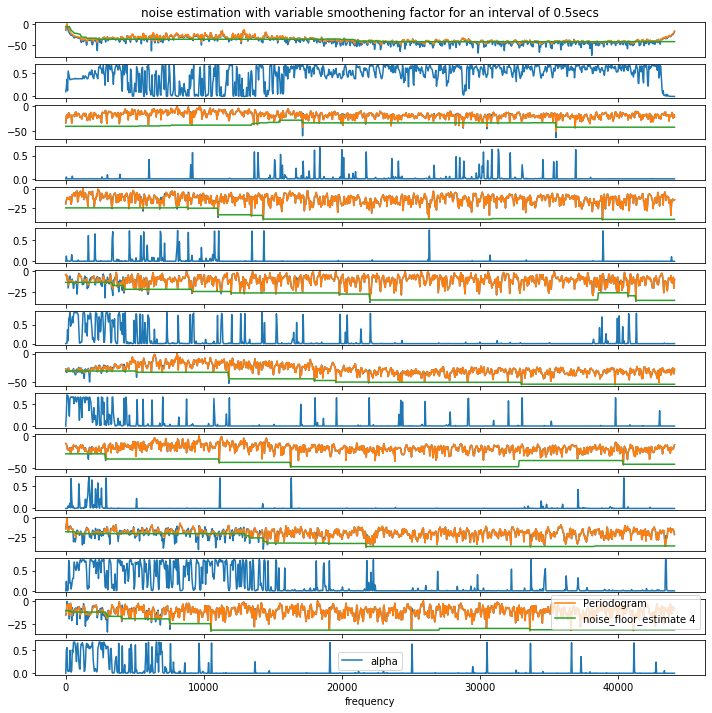

In [23]:
fig, ax = plt.subplots(niteration*2, 1, figsize=(12,12))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[2*i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[2*i].plot(f, 10*np.log10(periodogram[i]/max(periodogram[i])), label="Periodogram")
    ax[2*i].plot(f, noise_floor_est[i], label="noise_floor_estimate 4")
    ax[2*i + 1].plot(f, valpha[i], label="alpha")
ax[niteration*2-1].set_xlabel("frequency")
ax[niteration*2-1].legend()
ax[niteration*2-2].legend()

# Final picture of the noise floor estimator

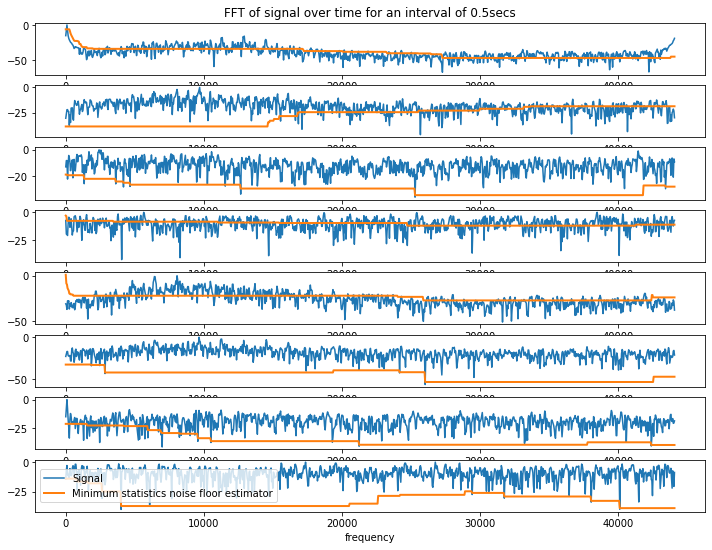

In [51]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("FFT of signal over time for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))), label="Signal")
    ax[i].plot(f, noise_floor_est[i], label="Minimum statistics noise floor estimator", linewidth="2")
ax[niteration-1].set_xlabel("frequency")
ax[niteration-1].legend()